# MS016 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS016'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 129 x 1175520 (2295.9 s), ~1.13 GB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1175520 (2295.9 s), ~9.0 MB, data loaded>

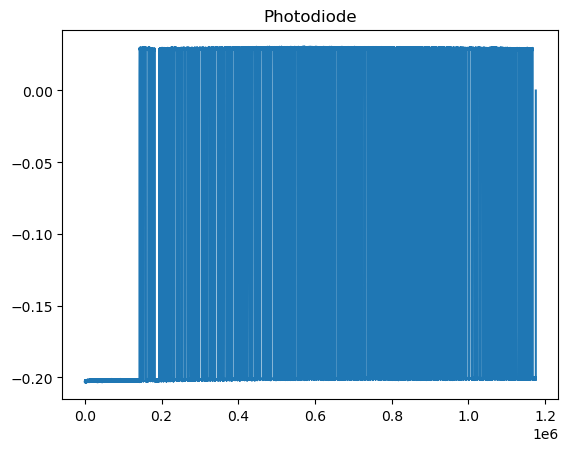

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [8]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCas1,A32sg_L,-4.195963,38.755833,1.548926,-4.923962,30.522125,-7.317985,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCas2,A24rv_L,-6.593655,39.555832,5.546539,-7.498945,32.166524,-2.505895,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,WM,NaN
2,LaCas3,Unknown,-8.991346,40.755832,9.544152,-10.170427,34.069446,2.265049,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
3,LaCas4,Unknown,-11.389038,41.955831,13.941527,-12.808619,36.020665,7.462891,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
4,LaCas5,Unknown,-13.786730,43.155830,17.939140,-15.421547,37.883783,12.121384,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,llem14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
150,llem15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
151,llem16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN
152,llem17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,OOB,NaN


## Load behavior

In [9]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,99.0,gain,422.337594,422.340221,426.624126,426.632066,4.283904,0.6,0.00,...,0.000000,0.750328,0.249672,0.000000,-0.162770,-0.162770,-0.162770,-0.162770,0.000000,0.000000
1,2,13.0,mix,433.215276,433.216051,437.734929,439.750044,4.518878,0.0,-0.50,...,-0.314669,0.452885,0.547115,0.314669,0.000000,0.286708,0.000000,0.000000,0.601377,0.286708
2,3,1.0,mix,444.358591,444.366438,450.960599,452.976403,6.594161,0.0,-0.30,...,-0.228809,0.276420,0.723580,-0.086463,-0.315272,-0.228809,-0.315272,-0.228809,0.000000,0.000000
3,4,67.0,gain,461.538127,461.538910,465.436259,467.452165,3.897349,0.3,0.00,...,0.000000,0.520871,0.479129,-0.484256,-0.484256,-0.471899,-0.484256,-0.471899,0.000000,0.000000
4,5,65.0,gain,472.625081,472.625810,474.298282,474.305471,1.672472,0.3,0.00,...,0.000000,0.404001,0.595999,0.000000,0.471899,0.471899,0.000000,0.000000,0.471899,0.471899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,126.0,loss,2264.226714,2264.238841,2266.764900,2268.781725,2.526059,-0.4,-1.12,...,-0.520385,0.545807,0.454193,0.000000,-0.520385,0.027180,-0.520385,0.027180,0.000000,0.000000
146,147,124.0,loss,2274.068316,2274.069053,2277.808500,2279.825500,3.739447,-0.4,-0.89,...,-0.450874,0.657831,0.342169,0.450874,0.000000,0.547564,0.000000,0.000000,0.450874,0.547564
147,148,136.0,loss,2289.736482,2289.745556,2293.783484,2295.800409,4.037928,-0.5,-1.40,...,-0.598099,0.552600,0.447400,0.000000,-0.598099,0.031239,-0.598099,0.031239,0.000000,0.000000
148,149,15.0,mix,2300.627949,2300.628908,2305.310593,2305.318230,4.681685,0.0,-0.80,...,-0.421867,0.145018,0.854982,0.000000,0.421867,0.421867,0.000000,0.000000,0.421867,0.421867


In [10]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [11]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.5)

10 blocks
..........

found matches for 120 of 156 pulses


In [12]:
print(slope, offset)

0.999987140770446 -43.73005154606085


## Make epochs

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [16]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 18192 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 19350 out of 19350 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of 129 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 18226 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 19350 out of 19350 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using ba

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~227.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~378.3 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,lmolf9,lacas11,lacas12,lagit5,lagit11,lagit12,lmls3_6,lmls3_7,lmls3_8,lils1_7,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.92,-1.92,-1.92,-1.92,0.00,0.00,0.889913,0.727143
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.045,0.455,0.00,0.41,0.00,0.00,0.91,0.41,-0.027961,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.120,-0.180,-0.36,-0.30,-0.36,-0.30,0.00,0.00,-0.142346,0.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.475,-0.475,-0.95,-0.30,-0.95,-0.30,0.00,0.00,0.484256,0.471899
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.44,-0.44,0.00,0.00,0.30,0.30,0.414383,0.471899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.560,-0.560,-1.12,-0.72,-1.12,-0.72,0.00,0.00,-0.520385,-0.547564
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.445,0.445,0.00,0.40,0.00,0.00,0.89,0.40,-0.450874,-0.547564
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.700,-0.700,-1.40,-0.90,-1.40,-0.90,0.00,0.00,-0.598099,-0.629338
148,NaN,NaN,[157],[156],NaN,[156],NaN,NaN,NaN,NaN,...,0.000,0.000,-0.16,-0.16,0.00,0.00,0.80,0.80,-0.262451,0.000000


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)